# 1 Image Processing

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models

# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Randomly rotate the image up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.RandomPerspective(),  # Random perspective transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

# Define the data loaders
train_dataset = ImageFolder(root='/Users/hong/thesis/code/data/Data/train', transform=transform)
validation_dataset = ImageFolder(root='/Users/hong/thesis/code/data/Data/val', transform=transform)
test_dataset = ImageFolder(root='/Users/hong/thesis/code/data/Data/test', transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0")  # Use GPU 0
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is not available.
done!


# Plot 8 bit Images

Image 1 Path: /Users/hong/thesis/code/data/Data/val/NFF/patient_WBQIQWJTEN/patient_WBQIQWJTEN_hospital_100_NFF_image_1.png
Image 2 Path: /Users/hong/thesis/code/data/Data/val/AFF/patient_AYCOTOMSHM/patient_AYCOTOMSHM_hospital_52_AFF_image_2.png
Image 3 Path: /Users/hong/thesis/code/data/Data/val/NFF/patient_YRLVNORJGP/patient_YRLVNORJGP_hospital_48_NFF_image_4.png
Image 4 Path: /Users/hong/thesis/code/data/Data/val/NFF/patient_HFSQPRBJLG/patient_HFSQPRBJLG_hospital_100_NFF_image_1.png
Image 5 Path: /Users/hong/thesis/code/data/Data/val/NFF/patient_NGBVBIUZPU/patient_NGBVBIUZPU_hospital_39_NFF_image_3.png


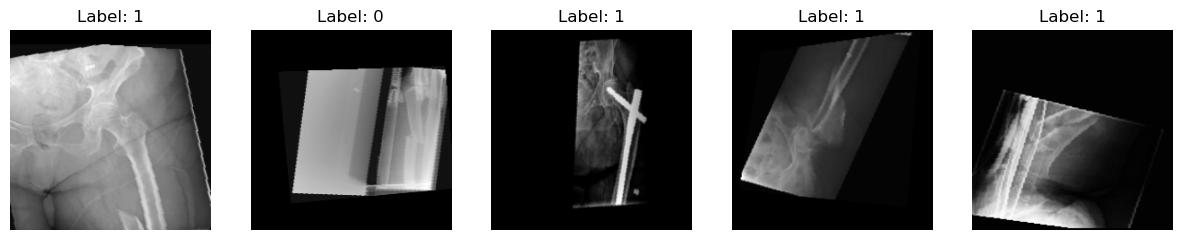

In [21]:
# Get some random indices from the validation dataset
random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# Print image file paths
for i, idx in enumerate(random_indices):
    filename = validation_dataset.samples[idx][0]  # Get the filename
    print(f"Image {i + 1} Path: {filename}")

# Plot images (transformed) with truncated names
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = validation_dataset[idx]  # Use validation_dataset directly
    filename = validation_dataset.samples[idx][0]  # Get the filename
    truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    plt.imshow(image[0], cmap='gray')  # Single-channel (grayscale)
    plt.axis('off')
plt.show()


# Class weights of Training Dataset

In [22]:
# ---------------------------------------------------------------------------------
# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# aff and nff numbers in test dataset
valid_aff_count = sum(1 for _, label in validation_dataset if label == 0)
valid_nff_count = sum(1 for _, label in validation_dataset if label == 1)

# aff and nff numbers in test dataset
test_aff_count = sum(1 for _, label in test_dataset if label == 0)
test_nff_count = sum(1 for _, label in test_dataset if label == 1)

print(f"train aff number: {train_aff_count}")
print(f"train nff number: {train_nff_count}")
print(f"validation aff number: {valid_aff_count}")
print(f"validation nff number: {valid_nff_count}")
print(f"test aff number: {test_aff_count}")
print(f"test nff number: {test_nff_count}")

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


train aff number: 696
train nff number: 2770
validation aff number: 82
validation nff number: 350
test aff number: 90
test nff number: 354
Class Weight for AFF (0): 2.4899
Class Weight for NFF (1): 0.6256


# ResNet152
# 80% Training, 10% Validation, and 10% Test
# Test Performance

## When used lr = 0.0001, step_size = 10, and gamma = 0.1, get a 96% accuracy on test data.

In [23]:
from torchvision.models import resnet152, ResNet152_Weights

# Settings
lr = 0.0001
step_size = 10
gamma = 0.1

# Class weights
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet152
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model = model.to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training (loss and accuracy)
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /Users/hong/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100.0%


KeyboardInterrupt: 

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

original_classes = train_loader.dataset.dataset.classes

# confusion matrix
with torch.no_grad():
    all_predictions = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Precision、Recall、F1 Score
classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
# 85 AFF 350 NFF

Confusion Matrix:
[[ 90   2]
 [ 20 323]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.82      0.98      0.89        92
         NFF       0.99      0.94      0.97       343

    accuracy                           0.95       435
   macro avg       0.91      0.96      0.93       435
weighted avg       0.96      0.95      0.95       435



In [6]:
batch_size = 64
test_dataset = ImageFolder(root='/local/data1/honzh073/data/8bit_patient/AFF', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


/opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [10,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [12,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [13,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [14,0,0] Assertion `t >= 0 && t <

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Save model

In [8]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'patient_level_resnet152.pth')


# Clean GPU memory

In [8]:
torch.cuda.empty_cache()


# VGG19

Epoch 1/50, Train Loss: 0.5835, Validation Loss: 0.6353, Train Acc: 59.55%, Validation Acc: 50.69%
Epoch 2/50, Train Loss: 0.6831, Validation Loss: 0.6891, Train Acc: 59.31%, Validation Acc: 61.52%
Epoch 3/50, Train Loss: 0.4625, Validation Loss: 0.5200, Train Acc: 65.04%, Validation Acc: 70.74%
Epoch 4/50, Train Loss: 0.3413, Validation Loss: 0.4756, Train Acc: 76.73%, Validation Acc: 83.64%
Epoch 5/50, Train Loss: 0.4801, Validation Loss: 0.4967, Train Acc: 79.50%, Validation Acc: 83.64%
Epoch 6/50, Train Loss: 0.4401, Validation Loss: 0.4642, Train Acc: 82.38%, Validation Acc: 73.04%
Epoch 7/50, Train Loss: 0.6192, Validation Loss: 0.4958, Train Acc: 80.48%, Validation Acc: 77.42%
Epoch 8/50, Train Loss: 0.5772, Validation Loss: 0.5972, Train Acc: 83.16%, Validation Acc: 88.25%
Epoch 9/50, Train Loss: 0.4576, Validation Loss: 0.4949, Train Acc: 84.91%, Validation Acc: 67.74%
Epoch 10/50, Train Loss: 0.3489, Validation Loss: 0.3995, Train Acc: 83.56%, Validation Acc: 83.18%
Epoch 11/

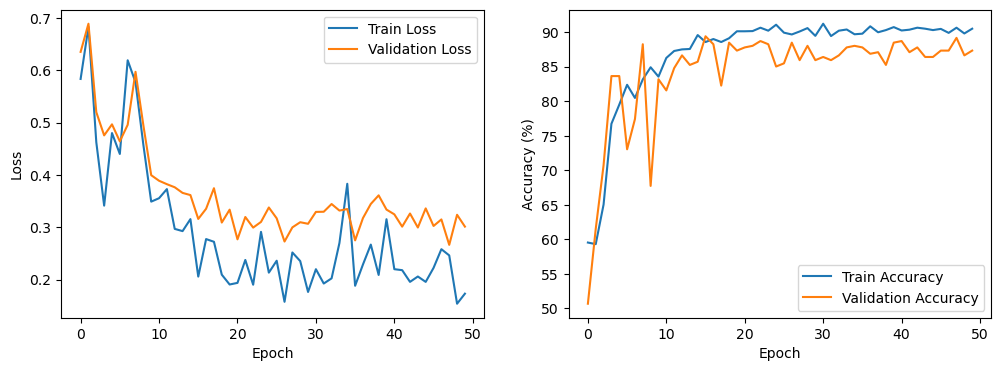

Test Loss: 0.2949, Test Acc: 88.28%


In [12]:
from torchvision.models import vgg19, VGG19_Weights

# Settings
lr = 0.0001
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# VGG19
model = models.vgg19(weights=VGG19_Weights.DEFAULT)  # Load the pre-trained VGG19 model
model.classifier[6] = nn.Linear(4096, 2)  # Modify the last fully connected layer
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training and validation
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)

    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")

    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test the model on the test dataset
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


In [13]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'patient_level_vgg19.pth')
